### Notebook to visualize FreeSurfer measaures on surfaces and parcellations

In [1]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from nibabel.freesurfer.mghformat import load
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import datasets, surface, plotting
import seaborn as sns
from pathlib import Path

In [2]:
### Load data
current_release = "Oct_2024"
FS_version = "7.3.2" #"6.0.1" #"7.3.2"
session = "ses-01"
dataset = "qpn"


dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}/"
tabular_dir = f"{release_dir}/tabular/"

# Current nipoppy manifest
manifest_csv = f"{release_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics.csv"

# Dx
dx_csv = f"{tabular_dir}/assessments/diagnosis.csv"

# imaging derivatives
FS_dir = f"{dataset_dir}/derivatives/freesurfer/v{FS_version}"
surf_dir = f"{FS_dir}/surfmaps/{session}/"

# ROI stats
DKT_csv = "/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/qpn/Aug_2024/agg_dfs/CT_DKT_df.csv"

# Surface maps
FS_surf_dir = f"{FS_dir}/surfmaps/{session}/"

# Results
figs_dir = f"{dataset_dir}/results/{session}/anat/figs/"
Path(f"{figs_dir}").mkdir(parents=True, exist_ok=True)

### Get analysis groups

In [3]:
dx_df = pd.read_csv(dx_csv)
dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

control_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "control"]["participant_id"].unique()
PD_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "PD"]["participant_id"].unique()

print(f"Control: {len(control_participants)}")
print(f"PD: {len(PD_participants)}")

dx_df.head()

Control: 69
PD: 194


,participant_id,redcap_event_name,Parkinson's disease in opinion of treating neurologist / Maladie de Parkinson selon l'avis du neurologue traitant,Final impression / Impression finale,"Determined diagnosis: If score = 0, Parkinson's Disease (PD) If score = 1, Progressive Supranuclear Palsy (PSP) If score = 2, Multiple System Atrophy (MSA) If score = 3, Corticobasal Syndrome (CBS) If score = 4, Dementia with Lewy Bodies (DLB) If score = 5, Frontotemporal Dementia (FTD) If score = 6, Essential Tremor (ET) If score = 7, REM Sleep Behaviour Disorder (RBD)",diagnosis_group_for_analysis,diagnosis_age
0,MNI0028,Baseline (Arm 1: C-OPN),Unsure / Incertain,Uncertain / Incertain,NaN,unknown,55.85
1,MNI0056,Baseline (Arm 1: C-OPN),Yes / Oui,Meets exclusion criteria / Rencontre des critè...,0.0,unknown,75.28
2,MNI0058,Baseline (Arm 1: C-OPN),Yes / Oui,Uncertain / Incertain,0.0,unknown,56.19
3,MNI0068,Baseline (Arm 1: C-OPN),NaN,NaN,0.0,PD,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),Yes / Oui,Meets criteria for Parkinson's disease / Répon...,0.0,PD,46.02


### Plot CT on surface
- e.g. lh_surf_concat_thickness_10mm.mgh

In [4]:
def read_FS_surf(FS_surf_dir,participant_id, meas="thickness", fwhm=10):
    """ Read freesurfer surfaces for a given participant and hemisphere """
    # sub-MNI0143_lh_surf_thickness_10mm.mgh

    surf_data = {}
    try:
        for hemi in ["lh", "rh"]:
            surf_file = f"{FS_surf_dir}/sub-{participant_id}_{hemi}_surf_{meas}_{fwhm}mm.mgh"
            surf_data[hemi] = nib.load(surf_file).get_fdata()
            surf_sum = np.sum(surf_data[hemi].flatten())

            # check if the surface is empty
            if surf_sum == 0:
                print(f"Empty surface for {participant_id} {hemi}")
                return None            
                    
        return surf_data
    
    except:
        print(f"Error reading {participant_id}")
        return None    
    


In [5]:
PD_surf_data_lh = []
PD_surf_data_rh = []
control_surf_data_lh = []
control_surf_data_rh = []

for participant_id in control_participants:
    surf_data = read_FS_surf(FS_surf_dir,participant_id)
    if surf_data is not None:    
        control_surf_data_lh.append(surf_data["lh"]) 
        control_surf_data_rh.append(surf_data["rh"]) 

for participant_id in PD_participants:
    surf_data = read_FS_surf(FS_surf_dir, participant_id)
    if surf_data is not None:
        PD_surf_data_lh.append(surf_data["lh"])
        PD_surf_data_rh.append(surf_data["rh"])

# Global averages for sanity checks
control_surf_lh_avg = np.mean(np.squeeze(control_surf_data_lh), axis=1)
control_surf_rh_avg = np.mean(np.squeeze(control_surf_data_rh), axis=1)

PD_surf_lh_avg = np.mean(np.squeeze(PD_surf_data_lh), axis=1)
PD_surf_rh_avg = np.mean(np.squeeze(PD_surf_data_rh), axis=1)

print(f"control_surf_lh_min_max: {np.min(control_surf_lh_avg)}, {np.max(control_surf_lh_avg)}")
print(f"control_surf_rh_min_max: {np.min(control_surf_rh_avg)}, {np.max(control_surf_rh_avg)}")

print(f"PD_surf_lh_min_max: {np.min(PD_surf_lh_avg)}, {np.max(PD_surf_lh_avg)}")
print(f"PD_surf_rh_min_max: {np.min(PD_surf_rh_avg)}, {np.max(PD_surf_rh_avg)}")


Empty surface for PD00457 rh
control_surf_lh_min_max: 2.023828170872461, 2.438457451970041
control_surf_rh_min_max: 2.051645157582269, 2.4010046712206634
PD_surf_lh_min_max: 1.9178069061041534, 2.392225189760772
PD_surf_rh_min_max: 1.8734384860976978, 2.402683645655268


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

<Axes: ylabel='Count'>

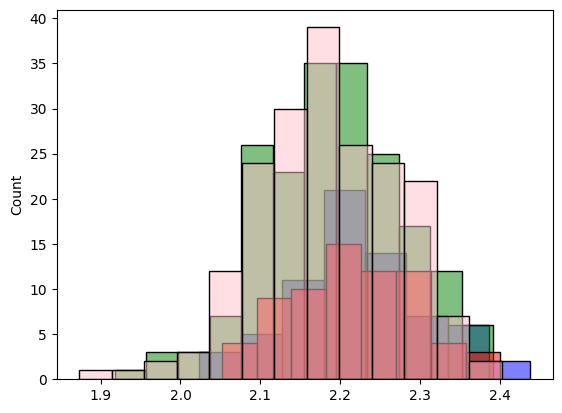

In [6]:
sns.histplot(control_surf_lh_avg.flatten(), color="blue", alpha=0.5)
sns.histplot(PD_surf_lh_avg.flatten(), color="green", alpha=0.5)
sns.histplot(control_surf_rh_avg.flatten(), color="red", alpha=0.5)
sns.histplot(PD_surf_rh_avg.flatten(), color="pink", alpha=0.5)


In [7]:
template_surface = "fsaverage" # "fsaverage" or "fsaverage5"

if template_surface == "fsaverage":
    fsaverage_dir = f"{FS_dir}/output/ses-01/fsaverage/"
    annot_dir = f"{fsaverage_dir}/label/"
    
else:
    fsaverage_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/surfaces/fsaverage5/"
    annot_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/parcellations/"

surf_dir = f"{fsaverage_dir}/surf/"

pial_lh = read_surface(f"{surf_dir}/lh.pial", itype='fs')
pial_rh = read_surface(f"{surf_dir}/rh.pial", itype='fs')

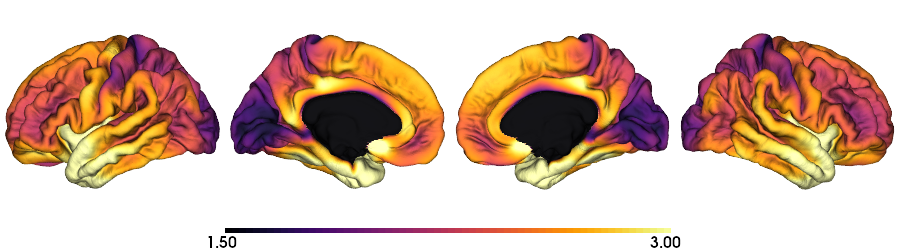

In [8]:
save_fig = True

# average across groups (axis = 0)
PD_surf_lh_avg = np.mean(np.squeeze(PD_surf_data_lh), axis=0)
PD_surf_rh_avg = np.mean(np.squeeze(PD_surf_data_rh), axis=0)

PD_surf_avg = [np.expand_dims(PD_surf_lh_avg, axis=(1)), np.expand_dims(PD_surf_rh_avg,axis=(1))]
PD_surf_avg = np.squeeze(np.concatenate(PD_surf_avg, axis=0))

if save_fig:
    save_file = f"{figs_dir}/CT_surf_PD.png"
else:
    save_file = None

# Plot the surfaces
plot_hemispheres( pial_lh, pial_rh, array_name=PD_surf_avg, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact", #filename=save_file,
                 nan_color=(255, 255, 255, 1), color_range=(1.5, 3), cmap="inferno", transparent_bg=True)



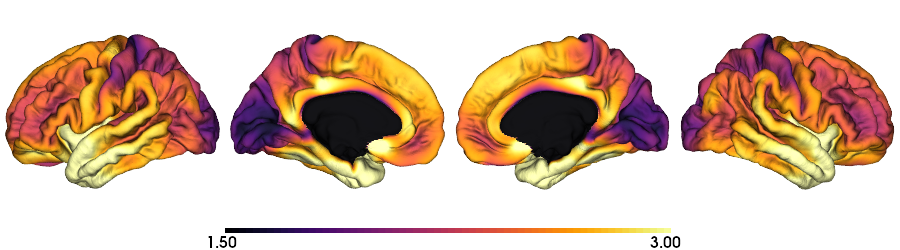

In [9]:
save_fig = True

# average across groups (axis = 0)
control_surf_lh_avg = np.mean(np.squeeze(control_surf_data_lh), axis=0)
control_surf_rh_avg = np.mean(np.squeeze(control_surf_data_rh), axis=0)

control_surf_avg = [np.expand_dims(control_surf_lh_avg, axis=(1)), np.expand_dims(control_surf_rh_avg,axis=(1))]
control_surf_avg = np.squeeze(np.concatenate(control_surf_avg, axis=0))

if save_fig:
    save_file = f"{figs_dir}/CT_surf_control.png"
else:
    save_file = None

# Plot the surfaces
plot_hemispheres( pial_lh, pial_rh, array_name=control_surf_avg, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact", #filename=save_file,
                 nan_color=(255, 255, 255, 1), color_range=(1.5, 3), cmap="inferno", transparent_bg=True)



### Difference between CTRL and PD

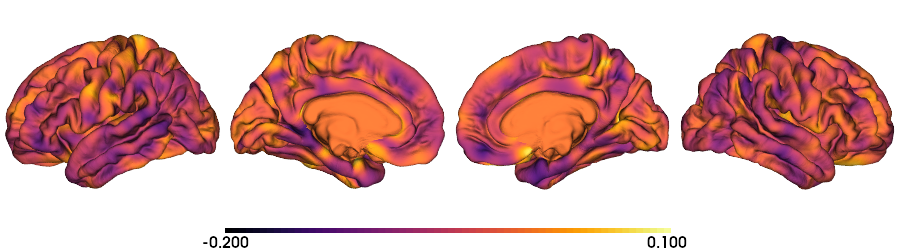

In [11]:
PD_minus_control_surf_avg = PD_surf_avg - control_surf_avg

# Plot the surfaces
plot_hemispheres( pial_lh, pial_rh, array_name=PD_minus_control_surf_avg, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(255, 255, 255, 1), color_range=(-.2,.1), cmap="inferno", transparent_bg=True)



### Plot labels on the surface

In [ ]:
# plot labels on surface
plot_hemispheres(pial_lh, pial_rh, array_name=labels, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='nipy_spectral', transparent_bg=True)

### Plot average CT per parcel

In [9]:
def get_mean_CT_per_parcel(labels, CT_vals, round_decimals=1):

    CT_parcel_df = pd.DataFrame()
    CT_parcel_df["CT"] = CT_vals
    CT_parcel_df["label"] = labels
    mean_CT_per_label_df = CT_parcel_df.groupby("label").mean().reset_index()
    label_CT_map_dict = dict(zip(mean_CT_per_label_df["label"], mean_CT_per_label_df["CT"]))
    CT_parcel_df["CT_parcel"] = CT_parcel_df["label"].replace(label_CT_map_dict)
    mean_CT_parcel = np.array(CT_parcel_df["CT_parcel"],dtype=np.float32).round(round_decimals)

    return mean_CT_parcel

### Controls

In [ ]:
# plot mean CT per parcel on surface
plot_array = get_mean_CT_per_parcel(labels, CTRL_surf)
cmap = "inferno"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True,color_bar='bottom') #color_range=(1.5, 4)

### PD

In [ ]:
# plot mean CT per parcel on surface
plot_array = get_mean_CT_per_parcel(labels, PD_surf)
cmap = "inferno"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom') #color_range=(1.5, 4),

### Difference between CTRL and PD

In [ ]:
# plot mean CT per parcel on surface
plot_thresh = 0.05
diff_surf = surf_dict["CTRL"] - surf_dict["PD"]
diff_surf[(diff_surf < plot_thresh) & (diff_surf > -plot_thresh)] = 0

plot_array = get_mean_CT_per_parcel(labels, diff_surf, round_decimals=2)
color_range = (-max(abs(plot_array)), max(abs(plot_array)))
cmap = "coolwarm"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom',color_range=color_range)

# Attempts to plot DKT parcels from aparc summaries...

### Surface and annotation files

- Possible surfaces: ["fsaverage", "fsaverage5"]
- Possible annot: 
    - "fsaverage": ["aparc", "aparc.a2009s", "Yeo2011_7Networks_N1000", "Yeo2011_17Networks_N1000"]
    - "fsaverage5": ["schaefer-500"]

In [ ]:
template_surface = "fsaverage" # "fsaverage" or "fsaverage5"
annot = "aparc" #"Yeo2011_7Networks_N1000"

if template_surface == "fsaverage":
    fsaverage_dir = f"{FS_dir}/output/ses-01/fsaverage/"
    annot_dir = f"{fsaverage_dir}/label/"
    
else:
    fsaverage_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/surfaces/fsaverage5/"
    annot_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/parcellations/"

surf_dir = f"{fsaverage_dir}/surf/"

pial_lh = read_surface(f"{surf_dir}/lh.pial", itype='fs')
pial_rh = read_surface(f"{surf_dir}/rh.pial", itype='fs')


if annot in ["aparc", "aparc.a2009s", "Yeo2011_7Networks_N1000", "Yeo2011_17Networks_N1000"]:
    annot_lh= f"{annot_dir}/lh.{annot}.annot"
    annot_rh= f"{annot_dir}/rh.{annot}.annot"
else:
    annot_lh= f"{annot_dir}/lh.{annot}_mics.annot"
    annot_rh= f"{annot_dir}/rh.{annot}_mics.annot"

labels = np.concatenate((nib.freesurfer.read_annot(annot_lh)[0], nib.freesurfer.read_annot(annot_rh)[0]), axis=0)

print(f"tempate surface: {template_surface}, annot: {annot}")
print(f"shape of concat array: {labels.shape}")

### Compare fsaverage and subject space labels

In [24]:
def get_label_info(annot_file):
    annot = nib.freesurfer.read_annot(annot_file)
    labels = annot[0]
    n_vertices = len(labels)
    label_idx = np.unique(labels)
    label_names = annot[2]
    
    return n_vertices, label_idx, label_names

In [ ]:
fsaverage_label_dir = f"{FS_dir}/output/ses-01/fsaverage/label/"
subject_label_dir = f"{FS_dir}/output/ses-01/sub-MNI0028/label/"

# Load the annotation file
parcel = "aparc"

for hemi in ["lh", "rh"]:
    fsaverage_annot_file = f"{fsaverage_label_dir}/{hemi}.{parcel}.annot"
    subject_annot_file = f"{subject_label_dir}/{hemi}.{parcel}.annot"

    print(f"{hemi} {parcel}")
    n_vertices, fsaverage_label_idx, fsaverage_label_names = get_label_info(fsaverage_annot_file)
    print(f"Number of vertices: {n_vertices}, n_idx: {len(fsaverage_label_idx)}, n_names: {len(fsaverage_label_names)}")
    
    n_vertices, subject_label_idx, subject_label_names = get_label_info(subject_annot_file)
    print(f"Number of vertices: {n_vertices}, n_idx: {len(subject_label_idx)}, n_names: {len(subject_label_names)}")
    

### Plot DKT values on brain

In [43]:
def get_mean_CT_labels_df(ct_df, group, hemi, annot_file, ct_cols):
    """
    Get mean CT values for each ROI per hemi per group
    """
    ct_labels_df = pd.DataFrame()

    mean_ct = ct_df[(ct_df["enrollment_group"]==group) & (ct_dkt_df["hemi"]==hemi)][ct_cols].mean(axis=0)    
    mean_ct_df = pd.DataFrame(mean_ct, columns=["mean_CT"]).reset_index().rename(columns={"index": "ROI"})
    
    # grab ROIs
    fs_annot = nib.freesurfer.read_annot(annot_file)
    ROIs = fs_annot[2]
    ROIs = [r.decode("utf-8") for r in ROIs] 
    n_ROIs = len(ROIs)
    print(f"Number of ROIs: {n_ROIs}")
    ROIs_df = pd.DataFrame(ROIs, columns=["ROI"])
    ROIs_df["ROI_index"] = np.arange(n_ROIs)

    # merge CT values with ROI names and index
    mean_ct_df = mean_ct_df.merge(ROIs_df, on="ROI")

    # ROI_index --> CT_val dict
    ROI_index_CT_dict = mean_ct_df.set_index("ROI_index")["mean_CT"].to_dict()

    # grab vertex wise labels
    labels = fs_annot[0]
    labels_df = pd.DataFrame(labels, columns=["ROI_index"])
    
    CT_df = pd.DataFrame(labels, columns=["ROI_index"])
    CT_df["mean_CT"] = CT_df["ROI_index"].map(ROI_index_CT_dict)

    return CT_df, mean_ct_df, ROI_index_CT_dict

In [ ]:
ct_dkt_df = pd.read_csv(DKT_csv)

demo_cols = ["participant_id", "sex", "enrollment_group", "hemi"]
ct_cols = list(set(ct_dkt_df.columns) - set(demo_cols))

group = "control"

lh_CT_df, _, _ = get_mean_CT_labels_df(ct_dkt_df, group, "lh", annot_lh, ct_cols)
rh_CT_df, _, _ = get_mean_CT_labels_df(ct_dkt_df, group, "rh", annot_rh, ct_cols)

CT_df = pd.concat([lh_CT_df, rh_CT_df], axis=0)
CT_df.head()

In [ ]:
# plot labels on surface
print("plotting CT values")
plot_array = CT_df["mean_CT"].values
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='BuPu', transparent_bg=True, color_bar='bottom', layout_style="compact",)